# Milestone Project 1: Food Vision Big Exercices

In [1]:
!nvidia-smi

Tue Apr 12 09:36:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-04-12 09:36:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-12 09:36:36 (75.2 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## 1. Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook (Transfer Learning Part 3: Scaling up). More specifically, it would be good to see:

* A confusion matrix between all of the model's predictions and true labels.
* A graph showing the f1-scores of each class.
* A visualization of the model making predictions on various images and comparing the predictions to the ground truth. 
  * For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label.

>Note: To compare predicted labels to test labels, it might be a good idea when loading the test data to set shuffle=False (so the ordering of test data is preserved alongside the order of predicted labels).

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [5]:
# Load in the data (takes 5-6 minutes in Google Colab)
train_data_load, ds_info = tfds.load(name="food101",
                                             split="train",
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

In [6]:
test_data_load, ds_info = tfds.load(name="food101",
                                             split="validation",
                                             shuffle_files=False, # so that the test_data always is in the same order
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

In [7]:
for image, label in test_data_load.take(1):
  print(image, label)

tf.Tensor(
[[[ 34  76 100]
  [ 30  72  96]
  [ 29  70  92]
  ...
  [ 81 101 108]
  [ 77  97 104]
  [ 69  89  96]]

 [[ 35  77 101]
  [ 32  74  98]
  [ 32  73  95]
  ...
  [ 75  95 102]
  [ 72  92  99]
  [ 68  88  95]]

 [[ 36  78 102]
  [ 34  76 100]
  [ 35  75 100]
  ...
  [ 68  88  97]
  [ 68  88  95]
  [ 67  87  94]]

 ...

 [[ 25  21  18]
  [ 25  21  18]
  [ 25  24  20]
  ...
  [137 152 155]
  [128 143 146]
  [122 137 140]]

 [[ 28  25  20]
  [ 28  25  20]
  [ 29  26  21]
  ...
  [137 150 158]
  [135 148 156]
  [135 148 154]]

 [[ 29  26  21]
  [ 30  27  22]
  [ 30  27  20]
  ...
  [134 147 156]
  [129 142 150]
  [131 144 152]]], shape=(382, 512, 3), dtype=uint8) tf.Tensor(29, shape=(), dtype=int64)


In [8]:
import tensorflow as tf
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  #image = image/255. # rescale image values (not required for EfficientNetBX)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [9]:
# Map preprocessing function to training (and parallelize)
train_data = train_data_load.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data_load.map(map_func=preprocess_img).batch(32)

In [10]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [78]:
# Load the fine tune model from the notes (Drive)
model = tf.keras.models.load_model("drive/MyDrive/Tensorflow_Zero_to_Mastery/101_food_classes_all_data_fine_tune_all_layers")

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

In [13]:
model.evaluate(test_data)

790/790 [==============================] - 110s 115ms/step - loss: 1.1131 - accuracy: 0.7715


[1.1131418943405151, 0.7715247273445129]

In [14]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [16]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [17]:
# To get our test labels we need to unravel our test_data BatchDataset (unbatch)
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy()) # currently test labels look like one integer with the class id, not one-hot encoded
y_labels[:10] # look at the first 10

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [18]:
pred_probs = model.predict(test_data)
pred_probs[:10]

array([[2.57787960e-05, 3.69599663e-12, 4.36411393e-11, ...,
        1.47414013e-07, 2.11478918e-10, 2.85430485e-03],
       [2.65197281e-10, 2.85543464e-12, 5.55883742e-11, ...,
        1.34678291e-09, 8.46346566e-08, 4.37895082e-13],
       [2.51913213e-10, 5.45947121e-10, 1.25420204e-11, ...,
        1.12662560e-10, 5.76635073e-10, 2.32981634e-10],
       ...,
       [1.36520635e-08, 2.01643975e-12, 2.39529674e-10, ...,
        3.19718579e-12, 3.39623891e-13, 1.68884839e-09],
       [1.75533242e-12, 3.05031066e-13, 1.15117508e-12, ...,
        5.78847246e-13, 2.77481831e-06, 2.76152560e-12],
       [3.99322715e-04, 9.91313143e-10, 5.95329827e-11, ...,
        4.87207444e-06, 1.09662848e-13, 9.97991800e-01]], dtype=float32)

In [19]:
y_pred = [pred.argmax() for pred in pred_probs]
y_pred[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [20]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels are print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  

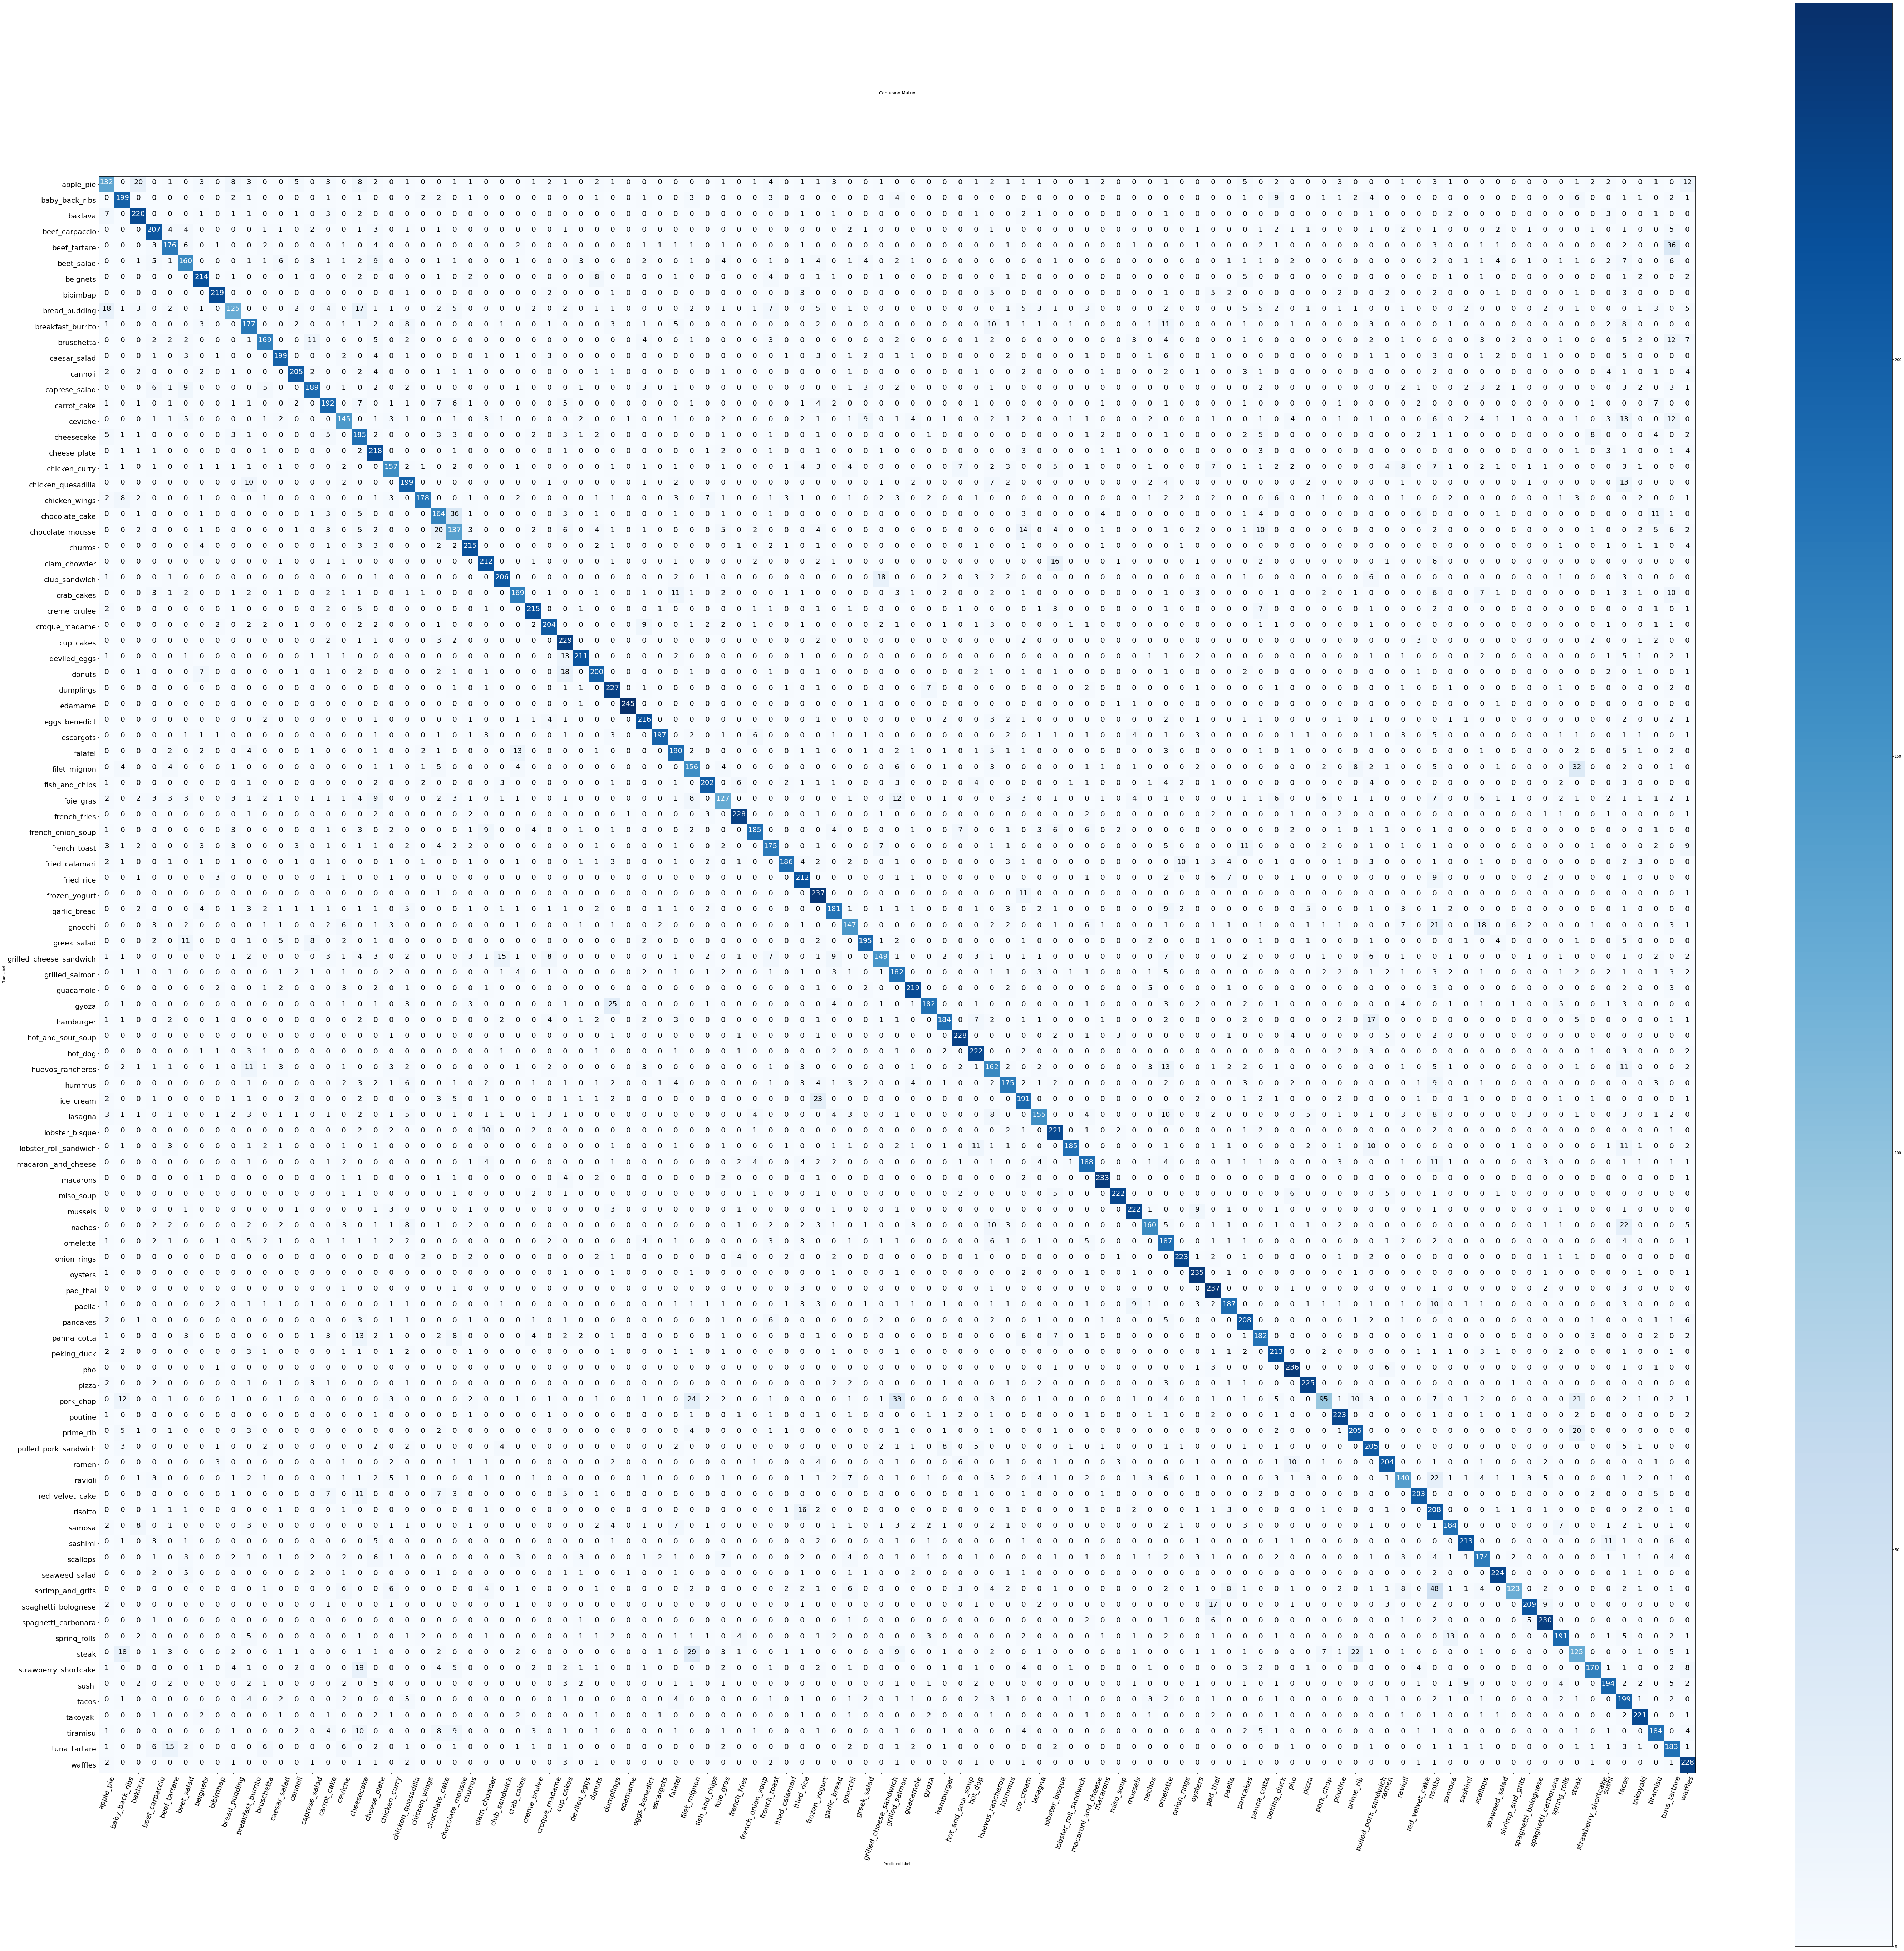

In [21]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=y_pred,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.63      0.53      0.58       250
           1       0.75      0.80      0.77       250
           2       0.79      0.88      0.83       250
           3       0.78      0.83      0.80       250
           4       0.75      0.70      0.72       250
           5       0.71      0.64      0.67       250
           6       0.84      0.86      0.85       250
           7       0.90      0.88      0.89       250
           8       0.72      0.50      0.59       250
           9       0.66      0.71      0.68       250
          10       0.80      0.68      0.73       250
          11       0.83      0.80      0.81       250
          12       0.86      0.82      0.84       250
          13       0.82      0.76      0.79       250
          14       0.75      0.77      0.76       250
          15       0.69      0.58      0.63       250
          16       0.54      0.74      0.62       250
          17       0.66    

In [23]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, y_pred, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.5751633986928104,
  'precision': 0.631578947368421,
  'recall': 0.528,
  'support': 250},
 '1': {'f1-score': 0.7698259187620891,
  'precision': 0.7453183520599251,
  'recall': 0.796,
  'support': 250},
 '10': {'f1-score': 0.7347826086956522,
  'precision': 0.8047619047619048,
  'recall': 0.676,
  'support': 250},
 '100': {'f1-score': 0.7715736040609137,
  'precision': 0.6686217008797654,
  'recall': 0.912,
  'support': 250},
 '11': {'f1-score': 0.8139059304703476,
  'precision': 0.8326359832635983,
  'recall': 0.796,
  'support': 250},
 '12': {'f1-score': 0.8418891170431211,
  'precision': 0.8649789029535865,
  'recall': 0.82,
  'support': 250},
 '13': {'f1-score': 0.785862785862786,
  'precision': 0.8181818181818182,
  'recall': 0.756,
  'support': 250},
 '14': {'f1-score': 0.7588932806324111,
  'precision': 0.75,
  'recall': 0.768,
  'support': 250},
 '15': {'f1-score': 0.6304347826086957,
  'precision': 0.6904761904761905,
  'recall': 0.58,
  'support': 250},
 '

In [24]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
    
class_f1_scores

{'apple_pie': 0.5751633986928104,
 'baby_back_ribs': 0.7698259187620891,
 'baklava': 0.830188679245283,
 'beef_carpaccio': 0.8038834951456312,
 'beef_tartare': 0.7242798353909465,
 'beet_salad': 0.6736842105263158,
 'beignets': 0.8475247524752475,
 'bibimbap': 0.8902439024390244,
 'bread_pudding': 0.5896226415094339,
 'breakfast_burrito': 0.6833976833976834,
 'bruschetta': 0.7347826086956522,
 'caesar_salad': 0.8139059304703476,
 'cannoli': 0.8418891170431211,
 'caprese_salad': 0.785862785862786,
 'carrot_cake': 0.7588932806324111,
 'ceviche': 0.6304347826086957,
 'cheese_plate': 0.7530224525043179,
 'cheesecake': 0.625,
 'chicken_curry': 0.6781857451403889,
 'chicken_quesadilla': 0.7595419847328243,
 'chicken_wings': 0.8054298642533937,
 'chocolate_cake': 0.6495049504950495,
 'chocolate_mousse': 0.5569105691056911,
 'churros': 0.8514851485148515,
 'clam_chowder': 0.8330058939096268,
 'club_sandwich': 0.8442622950819673,
 'crab_cakes': 0.7253218884120172,
 'creme_brulee': 0.86345381526

In [25]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)


In [26]:
f1_scores

,class_names,f1-score
33,edamame,0.983936
63,macarons,0.924603
64,miso_soup,0.913580
40,french_fries,0.906561
68,onion_rings,0.906504
...,...,...
39,foie_gras,0.581236
0,apple_pie,0.575163
22,chocolate_mousse,0.556911
93,steak,0.517598


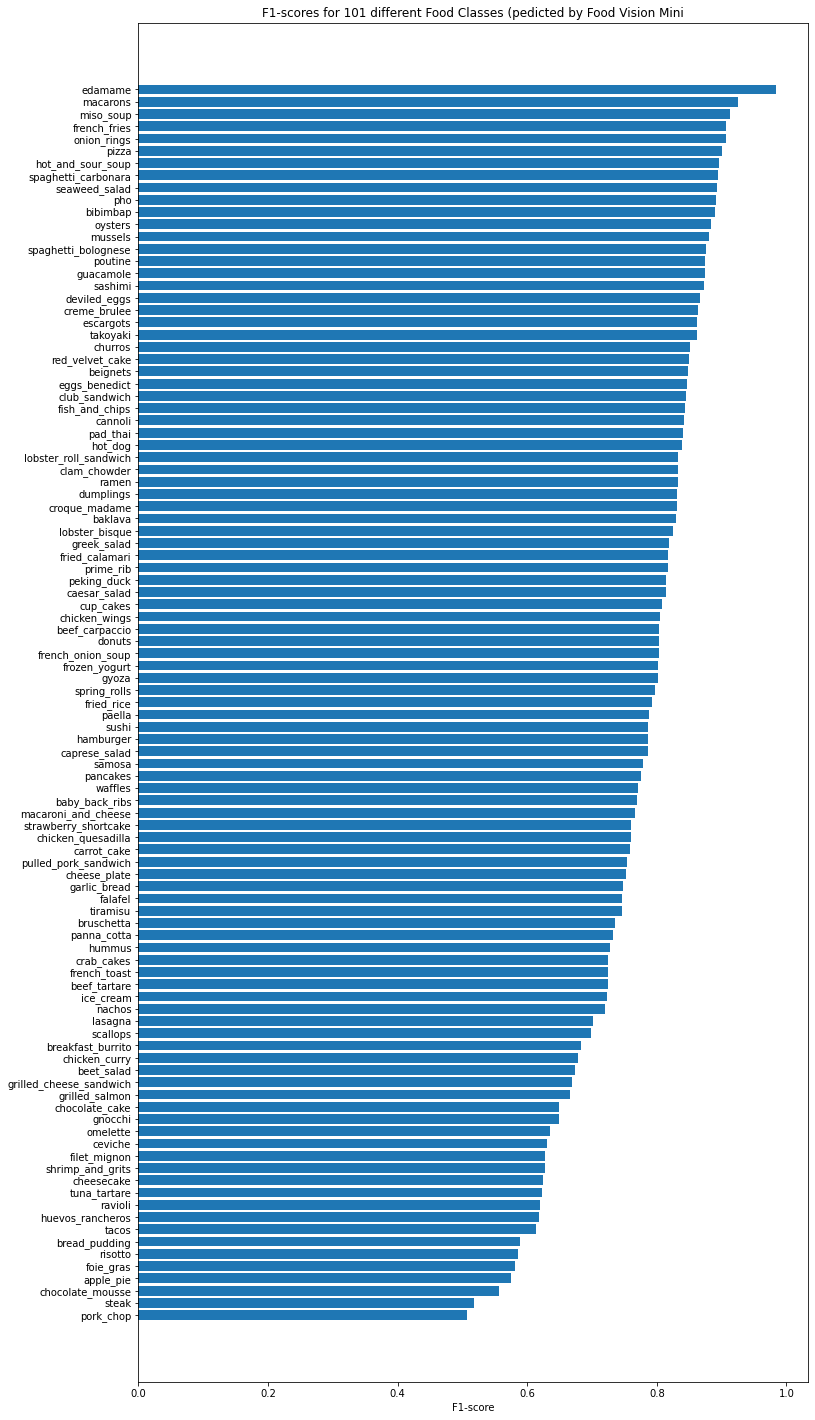

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"]);
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 different Food Classes (pedicted by Food Vision Mini")
ax.invert_yaxis() # reverse the order of our plot

In [28]:
# Finding the most wrong predictions
# Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({
                        "y_true": y_labels,
                        "y_pred": y_pred,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in y_pred]})
pred_df

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,29,29,0.995575,cup_cakes,cup_cakes
1,81,81,0.998283,ramen,ramen
2,91,91,0.999626,spaghetti_carbonara,spaghetti_carbonara
3,53,53,0.987084,hamburger,hamburger
4,97,97,0.999863,takoyaki,takoyaki
...,...,...,...,...,...
25245,38,38,1.000000,fish_and_chips,fish_and_chips
25246,86,86,0.999979,sashimi,sashimi
25247,76,46,0.507816,pizza,garlic_bread
25248,31,31,1.000000,donuts,donuts


In [29]:
# find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,29,29,0.995575,cup_cakes,cup_cakes,True
1,81,81,0.998283,ramen,ramen,True
2,91,91,0.999626,spaghetti_carbonara,spaghetti_carbonara,True
3,53,53,0.987084,hamburger,hamburger,True
4,97,97,0.999863,takoyaki,takoyaki,True


In [30]:
# Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)
top_100_wrong.head(20)

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
16129,65,69,1.000000,mussels,oysters,False
900,14,29,1.000000,carrot_cake,cup_cakes,False
9735,87,30,1.000000,scallops,deviled_eggs,False
13884,46,10,1.000000,garlic_bread,bruschetta,False
1113,72,67,0.999999,pancakes,omelette,False
6614,93,1,0.999999,steak,baby_back_ribs,False
15437,56,66,0.999999,huevos_rancheros,nachos,False
7455,43,68,0.999999,fried_calamari,onion_rings,False
13486,9,19,0.999998,breakfast_burrito,chicken_quesadilla,False
22441,16,17,0.999998,cheesecake,cheese_plate,False


In [49]:
[example for example in test_data.unbatch().take(3)][0][0].numpy()

array([[[ 32.007973 ,  74.00797  ,  98.00797  ],
        [ 32.516262 ,  73.516266 ,  95.516266 ],
        [ 36.433033 ,  72.14317  ,  95.94132  ],
        ...,
        [ 73.05832  ,  93.05832  , 103.04107  ],
        [ 75.82466  ,  95.82466  , 103.47962  ],
        [ 72.883064 ,  92.883064 ,  99.883064 ]],

       [[ 34.751595 ,  76.751595 , 100.77232  ],
        [ 36.919323 ,  76.91933  , 101.91933  ],
        [ 34.583862 ,  70.15529  ,  94.48565  ],
        ...,
        [ 74.312454 ,  94.25442  , 105.42853  ],
        [ 67.94196  ,  87.94196  ,  97.04974  ],
        [ 67.66355  ,  87.66355  ,  94.73817  ]],

       [[ 36.120537 ,  77.84789  , 103.51371  ],
        [ 38.691967 ,  78.69196  , 104.45536  ],
        [ 34.9493   ,  71.4477   ,  97.498405 ],
        ...,
        [ 69.374954 ,  88.374954 , 102.374954 ],
        [ 69.34472  ,  89.34472  , 100.201836 ],
        [ 69.52679  ,  89.52679  ,  98.357765 ]],

       ...,

       [[ 19.576307 ,  17.866407 ,  15.629774 ],
        [ 2

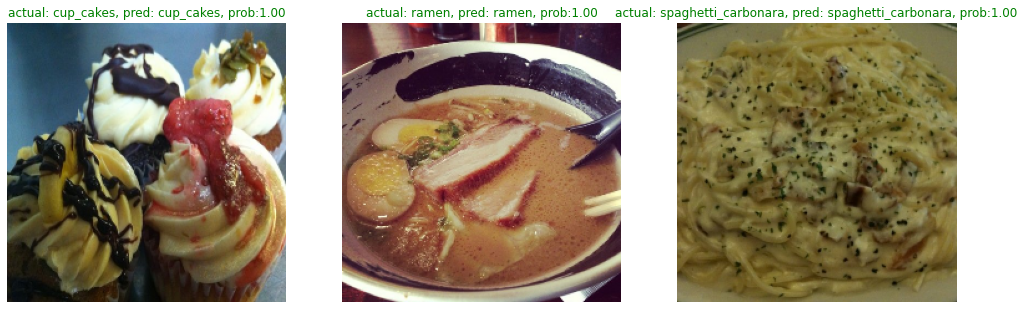

In [52]:
# Make preds on a series of random images
import os 
import random
plt.figure(figsize=(17, 10))
examples = [example for example in test_data.unbatch().take(3)]
for i in range(3):
  
  # Load the image and make predictions
  img = examples[i][0].numpy()
  true_class = class_names[examples[i][1].numpy()]

  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it to class_names list
  # print(pred_prob)
  # print(pred_class)

  # Plot the image(s)
  
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if true_class == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {true_class}, pred: {pred_class}, prob:{pred_prob.max():.2f}", color=title_color)
  plt.axis(False)

## 3. Take 3 of your own photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.

In [53]:
images_dir = "drive/MyDrive/Tensorflow_Zero_to_Mastery/Images/06_exercices"
image_names = os.listdir(images_dir)
image_names

['curry.jpg', 'nachos.jpg', 'pizza.jpg']

(-0.5, 3999.5, 2999.5, -0.5)

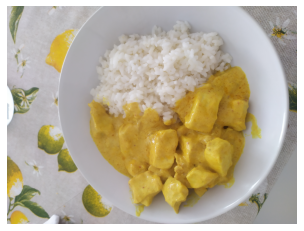

In [54]:
image = plt.imread(images_dir + "/" + image_names[0])
plt.imshow(image)
plt.axis(False)

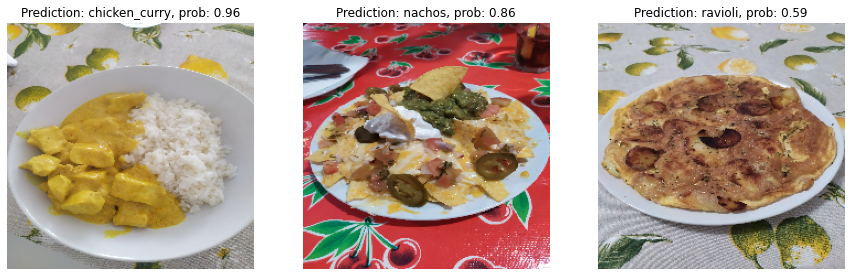

In [57]:
plt.figure(figsize=(15, 10))
for i, img_name in enumerate(image_names):
  plt.subplot(1, 3, i+1)
  image = tf.io.read_file(images_dir + "/" + img_name)
  # Decode image into tensor
  image = tf.io.decode_image(image, channels=3)
  image = tf.image.rot90(image, k=-1)
  image, _ = preprocess_img(image, None)
  pred_probs = model.predict(tf.expand_dims(image, 0))
  pred_class = class_names[pred_probs.argmax()]
  plt.imshow(image/255.)
  plt.title(f"Prediction: {pred_class}, prob: {pred_probs.max():.2f}")
  plt.axis(False)

## 3. Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use EfficientNetB4 as the base model instead of EfficientNetB0. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider?

In [60]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

In [63]:
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

In [65]:
base_model.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

In [76]:
model = model.layers[1] = base_model

In [77]:
model.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

In [83]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor="val_accuracy",
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     verbose=0) # don't print whether or not model is being saved

In [84]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [85]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# x = layers.Rescaling(1./255) # not needed for EfficientNet
x = base_model(inputs, training=False) # make sure layers which should be in inference mode only stay like dat (batchnorm)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) # output layer should be in float32 format to be numerically stable (it would loose precision with float16)
model_b4 = tf.keras.Model(inputs, outputs)

# Compile the model
model_b4.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [86]:
model_b4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 17,854,916
Trainable params: 181,093
Non-traina

In [88]:
# Check the dtype_policy attributes of layers in the base_model
for layer in model_b4.layers[1].layers: # check the layers of the base model (layer at index 1 of model)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_6 False float32 <Policy "float32">
rescaling_5 False float32 <Policy "mixed_float16">
normalization_5 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1b_dwconv False float32 <Policy "mixed_float16">
block1b_bn False float32 <Po

In [90]:
# Fit the feature extraction model with callbacls
history_101_food_classes_feature_extract_b4 = model_b4.fit(train_data,
                                                        epochs=3,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)),
                                                        callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                                experiment_name="efficientnetb0_101_classes_all_data_feature_extract_b4"),
                                                                    model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract_b4/20220412-102355
Epoch 1/3
2368/2368 [==============================] - 732s 294ms/step - loss: 1.8694 - accuracy: 0.5362 - val_loss: 1.3346 - val_accuracy: 0.6544
Epoch 2/3
2368/2368 [==============================] - 675s 284ms/step - loss: 1.3880 - accuracy: 0.6406 - val_loss: 1.2386 - val_accuracy: 0.6737
Epoch 3/3
2368/2368 [==============================] - 686s 289ms/step - loss: 1.2376 - accuracy: 0.6756 - val_loss: 1.1943 - val_accuracy: 0.6835


In [91]:
model_b4.evaluate(test_data)

790/790 [==============================] - 222s 281ms/step - loss: 1.1849 - accuracy: 0.6841


[1.1848777532577515, 0.6840792298316956]

It's worse than the efficientnetB0 version and is slower to train (skipping fine tuning as it would take too long)

## 4. Name one important benefit of mixed precision training, how does this benefit take place?

It makes training faster as it uses less bits for each number, using less decimals on multiplications and thus having a bit less precision.